The goal of this notebook is to look at the effect of 1) Standardization 2) Voting Classification when training models.
I used the Iris Dataset, selecting only Iris-Versicolor and Iris-Virginica (for the ROC evaluation)

In [2]:
#loading libraries
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score
#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [9]:
iris = datasets.load_iris()
X = iris.data[50:,[1,2]]
y = iris.target[50:]
#encoded labels to [0,1]
le = LabelEncoder()
yy = le.fit_transform(y)
#split data into training/testing samples
X_train, X_test, y_train, y_test = train_test_split(X, yy, test_size=.5, random_state=1) 

In [10]:
#define voting classifiers
from sklearn.ensemble import VotingClassifier
clf_1 = LogisticRegression()
clf_2 = DecisionTreeClassifier()
clf_3 = KNeighborsClassifier()
vf = VotingClassifier(estimators=[('LR', clf_1), ('DT', clf_2),('KNN', clf_3)],voting='soft', weights=[1, 1, 1])
#save all classifiers in an array
mods = []
mods.append(('LR',clf_1))
mods.append(('DT',clf_2))
mods.append(('KNN',clf_3))
mods.append(('VF',vf))

In [11]:
#quick look at the training accuracy
results = []
names = []
for name, model in mods:
    #print name, model
    cv_results = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.966667 (0.066667)
DT: 0.916667 (0.153659)
KNN: 0.975000 (0.053359)
VF: 0.983333 (0.050000)


Comments : a Voting Classifier (voting=soft means the classifier predicts the class label based on the argmax of the 
sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers) seems to give the best result.

In [13]:
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
%matplotlib inline

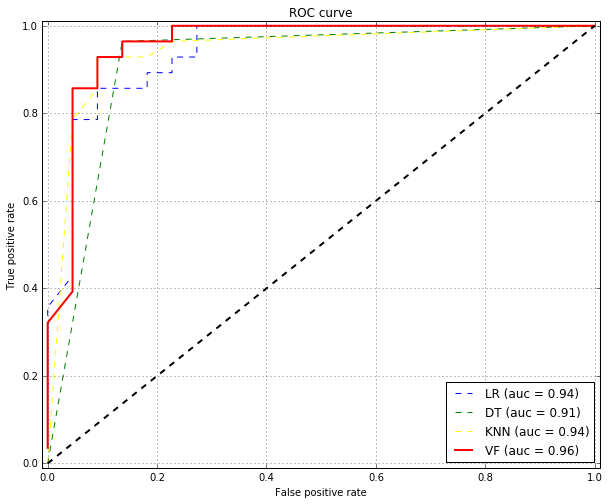

In [17]:
#ROC curves
colors = ['blue','green','yellow','red']
linesstyles =['--','--','--','-']
linewidth =[1,1,1,2]
plt.figure(figsize=(10,8))
for model,name,clr,ls,lw in zip(mods,mods,colors,linesstyles,linewidth):
    #print name, model
    model[1].fit(X_train,y_train)
    prediction = model[1].predict_proba(X_test)
    y_pred = prediction[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,color=clr,linestyle=ls,linewidth=lw,label='%s (auc = %0.2f)' %(model[0],roc_auc))

plt.plot([0,1],[0,1],'k--',linewidth=2)
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid()
plt.show()

Now we look at the effect of Standardization, meaning transforming data in order to scale them to have mean=0, and std=1.
The use of Pipeline makes the process quite easy.

In [18]:
#define based classifiers and voting majority
base_models = [LogisticRegression(),DecisionTreeClassifier(), KNeighborsClassifier()]
pipe_models =[]
for mod in base_models :
    #print mod
    pipe_models.append(Pipeline([('scl',StandardScaler()),('clf',mod)]))
vf = VotingClassifier(estimators=[('LR scaled', base_models[0]), 
                                  ('DT scaled', base_models[1]),
                                  ('KNN scaled', base_models[2])],
                      voting='soft', weights=[1, 1, 1])
pipe_models.append(vf)
name_models =['LogisticRegression (scaled)',
              'DecisionTreeClassifier (scaled)', 
              'KNeighborsClassifier (scaled)',
              'Voting Classifier (scaled)']

In [19]:
#look at the training accuracy
res=[]
for name,model in zip(name_models,pipe_models):
    #print model
    results = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc')
    res.append(results)
    msg = "%s %f (%f)" % (name, results.mean(), results.std())
    print(msg)

LogisticRegression (scaled) 1.000000 (0.000000)
DecisionTreeClassifier (scaled) 0.916667 (0.153659)
KNeighborsClassifier (scaled) 0.950000 (0.150000)
Voting Classifier (scaled) 0.983333 (0.050000)


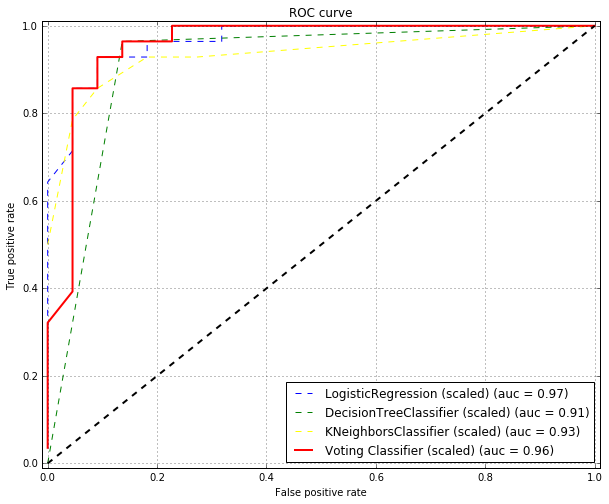

In [20]:
#ROC curves
colors = ['blue','green','yellow','red']
linesstyles =['--','--','--','-']
linewidth =[1,1,1,2]
plt.figure(figsize=(10,8))
for model,name,clr,ls,lw in zip(pipe_models,name_models,colors,linesstyles,linewidth):
    #print name, model
    model.fit(X_train,y_train)
    prediction = model.predict_proba(X_test)
    y_pred = prediction[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,color=clr,linestyle=ls,linewidth=lw,label='%s (auc = %0.2f)' %(name,roc_auc))

plt.plot([0,1],[0,1],'k--',linewidth=2)
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid()
plt.show()

Comments : LogisticRegression seems to benefit the most from the Standardization.